## Libraries and Import Packages

In [1]:
pip install nltk


In [2]:
pip install seaborn

In [3]:
pip install scikit-learn

In [4]:
import re                                                     #for regular expressions
import nltk                                                     #for text manipulation
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [5]:
pd.set_option("display.max_colwidth",200)
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Train Dataset

In [7]:
train = pd.read_csv('/content/drive/MyDrive/Mahiti/New/train.csv')

In [8]:
tweet = train.columns.values[2]
sentiment = train.columns.values[1]
tweet, sentiment

('tweet', 'label')

In [9]:
train[train['label'] == 0].head(15)

,id,label,tweet
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T
5,6,0,or i just worry too much?
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight
10,11,0,I must think about positive..
12,13,0,this weekend has sucked so far
13,14,0,jb isnt showing in australia any more!
14,15,0,ok thats it you win.


In [10]:
train[train['label'] == 1].head(10)

,id,label,tweet
2,3,1,omg its already 7:30 :O
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
8,9,1,handed in my uniform today . i miss you already
9,10,1,hmmmm.... i wonder how she my number @-)
11,12,1,thanks to all the haters up in my face all day! 112-102
17,18,1,Feeling strangely fine. Now I'm gonna go listen to some Semisonic to celebrate
22,23,1,You're the only one who can see this cause no one else is following me this is for you because you're pretty awesome
28,29,1,"goodbye exams, HELLO ALCOHOL TONIGHT"
38,39,1,uploading pictures on friendster
41,42,1,(: !!!!!! - so i wrote something last week. and i got a call from someone in the new york office... http://tumblr.com/xcn21w6o7


In [11]:
train.shape

(45553, 3)

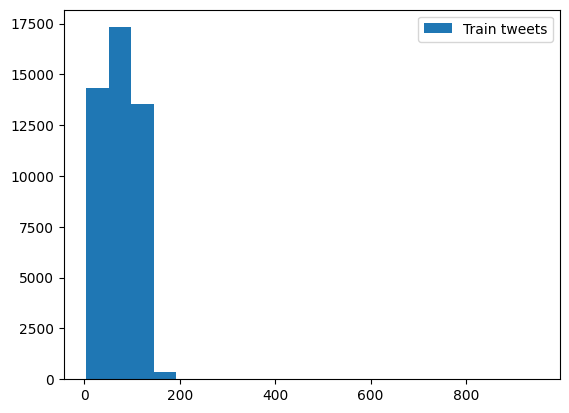

In [12]:
length_train_dataset = train['tweet'].str.len()
plt.hist(length_train_dataset, bins=20,label="Train tweets")
plt.legend()
plt.show()

In [13]:
train['label'].value_counts()

1    24262
0    21291
Name: label, dtype: int64

## Test Dataset

In [14]:
test = pd.read_csv('/content/drive/MyDrive/Mahiti/test1.csv')

In [15]:
test.shape

(17197, 2)

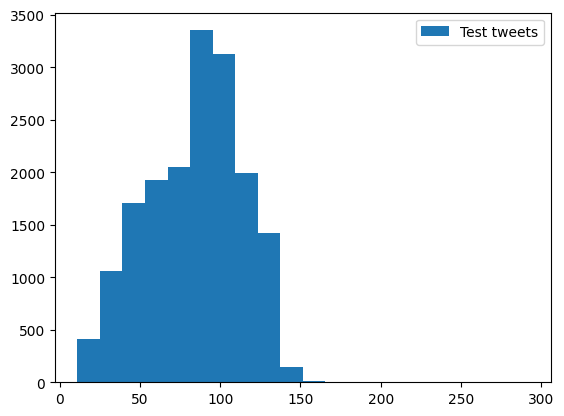

In [16]:
length_test_dataset = test['tweet'].str.len()
plt.hist(length_test_dataset, bins=20,label="Test tweets")
plt.legend()
plt.show()

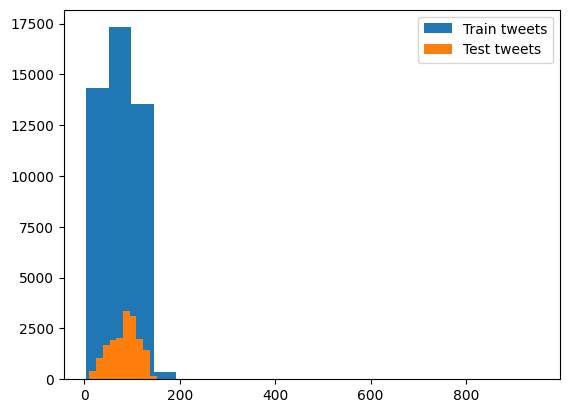

In [17]:
length_train_dataset = train['tweet'].str.len()
length_test_dataset = test['tweet'].str.len()
plt.hist(length_train_dataset, bins=20,label="Train tweets")
plt.hist(length_test_dataset, bins=20,label="Test tweets")
plt.legend()
plt.show()

In [18]:
combine=train.append(test,ignore_index=True) #train and test dataset are combined
combine.shape

<ipython-input-18-846eabe7f51a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combine=train.append(test,ignore_index=True) #train and test dataset are combined


(62750, 3)

# Data Preprocessing

### Emoji handles

In [19]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


### Removing twitter handles


In [20]:
def remove_pattern(input_text,pattern):
    r= re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

In [21]:
combine = pd.DataFrame(train)

In [22]:
combine['tidy_tweet'] = np.vectorize(remove_pattern)(combine['tweet'],"@[\w]*")
combine.head()

,id,label,tweet,tidy_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T,i think mi bf is cheating on me!!! T_T


In [23]:
combine['tidy_tweet'] = combine['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
combine.head(10)

<ipython-input-23-b193699ac8a6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  combine['tidy_tweet'] = combine['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")


,id,label,tweet,tidy_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my APL friend
1,2,0,I missed the New Moon trailer...,I missed the New Moon trailer
2,3,1,omg its already 7:30 :O,omg its already O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,Omgaga Im sooo im gunna CRy I ve been at this dentist since I was suposed just get a crown put on mins
4,5,0,i think mi bf is cheating on me!!! T_T,i think mi bf is cheating on me T T
5,6,0,or i just worry too much?,or i just worry too much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,Juuuuuuuuuuuuuuuuussssst Chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,Sunny Again Work Tomorrow TV Tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today i miss you already
9,10,1,hmmmm.... i wonder how she my number @-),hmmmm i wonder how she my number


## Removing short words (a,is,so etc..)

In [24]:
combine['tidy_tweet'] = combine['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #removing words whose length is less than 3

In [25]:
combine.head()

,id,label,tweet,tidy_tweet
0,1,0,is so sad for my APL friend.............,friend
1,2,0,I missed the New Moon trailer...,missed Moon trailer
2,3,1,omg its already 7:30 :O,already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,Omgaga sooo gunna been this dentist since suposed just crown mins
4,5,0,i think mi bf is cheating on me!!! T_T,think cheating


### Tokenization

In [26]:
tokenized_tweet = combine['tidy_tweet'].apply(lambda x:x.split()) #it will split all words by whitespace
tokenized_tweet.head()

0                                                                         [friend]
1                                                          [missed, Moon, trailer]
2                                                                        [already]
3    [Omgaga, sooo, gunna, been, this, dentist, since, suposed, just, crown, mins]
4                                                                [think, cheating]
Name: tidy_tweet, dtype: object

In [27]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combine['tidy_tweet'] = tokenized_tweet

In [28]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) #it will stemmatized all words in tweet
print(tokenized_tweet)

0                                                                                                                                                                                             [f, r, i, e, n, d]
1                                                                                                                                                      [m, i, s, s, e, d,  , m, o, o, n,  , t, r, a, i, l, e, r]
2                                                                                                                                                                                          [a, l, r, e, a, d, y]
3            [o, m, g, a, g, a,  , s, o, o, o,  , g, u, n, n, a,  , b, e, e, n,  , t, h, i, s,  , d, e, n, t, i, s, t,  , s, i, n, c, e,  , s, u, p, o, s, e, d,  , j, u, s, t,  , c, r, o, w, n,  , m, i, n, s]
4                                                                                                                                                                   

### Removing Hashtags

In [29]:
#collect hashtags
def hashtag_extract(x):
    hashtags=[]
    for i in x: #loop over words contain in tweet
        ht = re.findall(r"#(\w+)",i)
        hashtags.append(ht)
    return hashtags

## Most of hashtags in tweet sentiment

In [30]:
#extracting hashtags from non racist tweets

ht_regular = hashtag_extract(combine['tidy_tweet'][combine['label']==0])

#extracting hashtags from racist tweets
ht_negative=hashtag_extract(combine['tidy_tweet'][combine['label']==1])
ht_regular = sum(ht_regular,[])
ht_negative = sum(ht_negative,[])


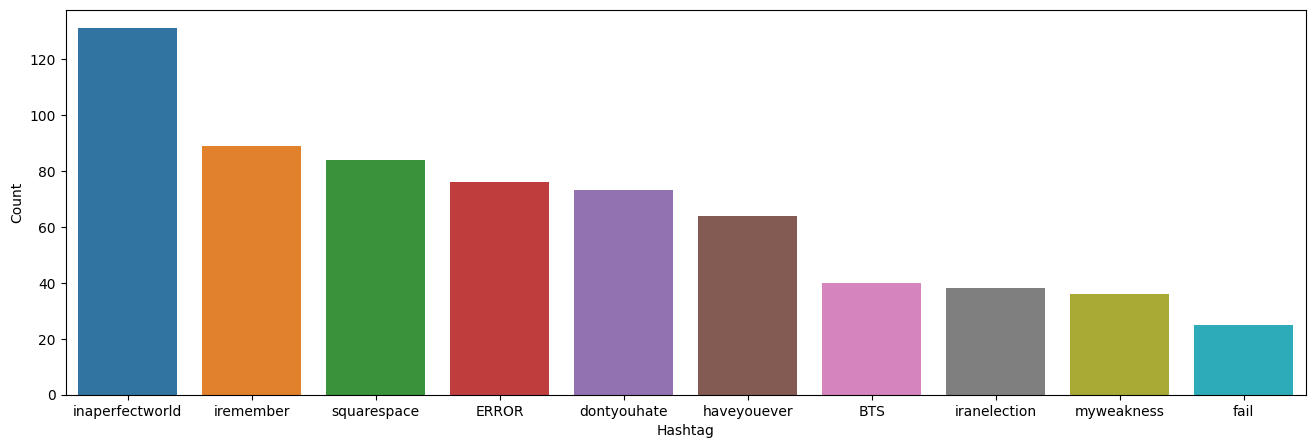

In [31]:
#non-racist tweets

nonracist_tweets = nltk.FreqDist(ht_regular)
df1 = pd.DataFrame({'Hashtag': list(nonracist_tweets.keys()),'Count':list(nonracist_tweets.values())})


df1 = df1.nlargest(columns="Count",n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=df1, x="Hashtag", y="Count")
ax.set(ylabel = "Count")
plt.show()

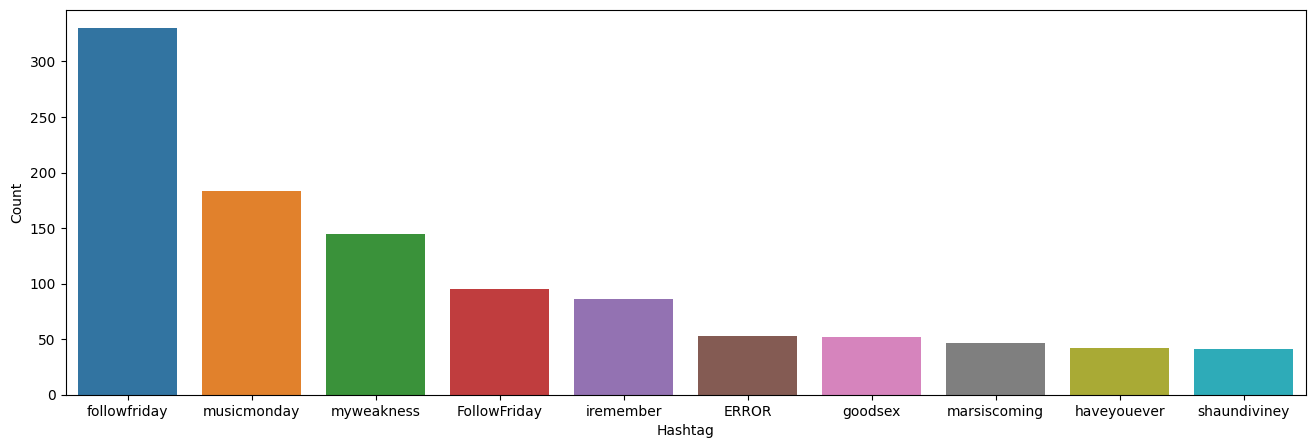

In [32]:
#racist tweets

racist_tweets = nltk.FreqDist(ht_negative)
df2 = pd.DataFrame({'Hashtag': list(racist_tweets.keys()),'Count': list(racist_tweets.values())}) #count number of occurrence of particular word



df2 = df2.nlargest(columns = "Count",n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=df2, x="Hashtag",y="Count")
plt.show()

##feature Extraction


In [33]:
pip install gensim

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

In [35]:
#Bag-of-words

#Each row in matrix M contains the frequency of tokens(words) in the document D(i)

bow_vectorizer = CountVectorizer(max_df=0.90 ,min_df=2 , max_features=1000,stop_words='english')
bow = bow_vectorizer.fit_transform(combine['tidy_tweet']) # tokenize and build vocabulary
bow.shape

(45553, 1000)

## Piechart on Data

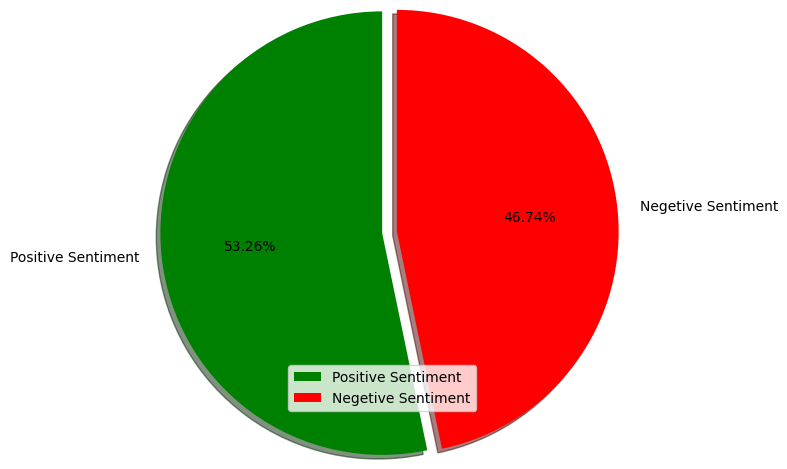

In [36]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment']
slices = [(train[sentiment] != 0).sum(), (train[sentiment] == 0).sum()]
colors = ['g', 'r']
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%')
plt.legend()

## Most used Words - Word Cloud

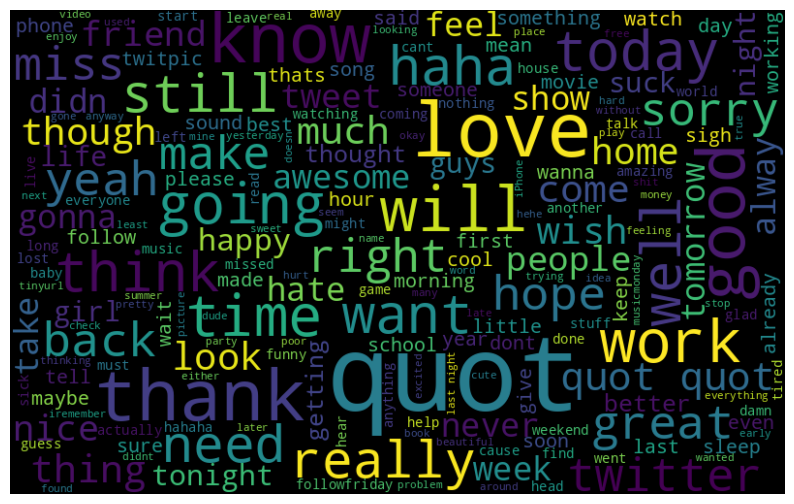

In [37]:
all_words = ' '.join([text for text in combine['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

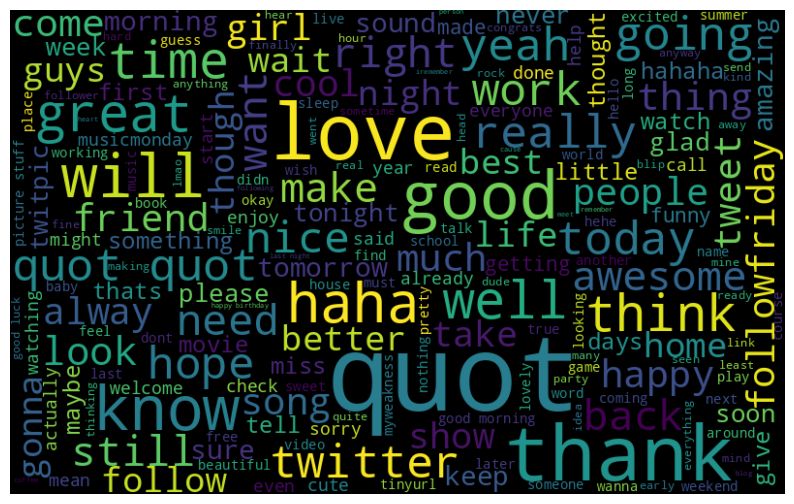

In [38]:
#racist tweet

negative_words= ' '.join([text for text in combine['tidy_tweet'][combine['label']==1]])
wordcloud= WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

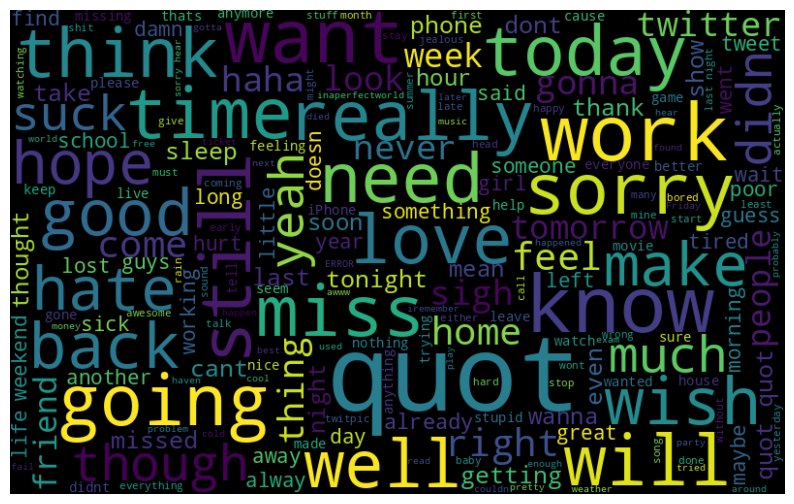

In [39]:
normal_words= ' '.join([text for text in combine['tidy_tweet'][combine['label']==0]])
wordcloud= WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(normal_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [40]:
combine=combine.fillna(0) #replace all null values by 0
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bow, combine['label'],
                                                    test_size=0.2, random_state=69)

In [41]:
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (36442, 1000)
X_test_shape :  (9111, 1000)
y_train_shape :  (36442,)
y_test_shape :  (9111,)


# Naive Bayes Classifier

In [42]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train)
predicted_naive = model_naive.predict(X_test)

Confusion Matrix:
[[11026  5954]
 [ 4264 15198]]


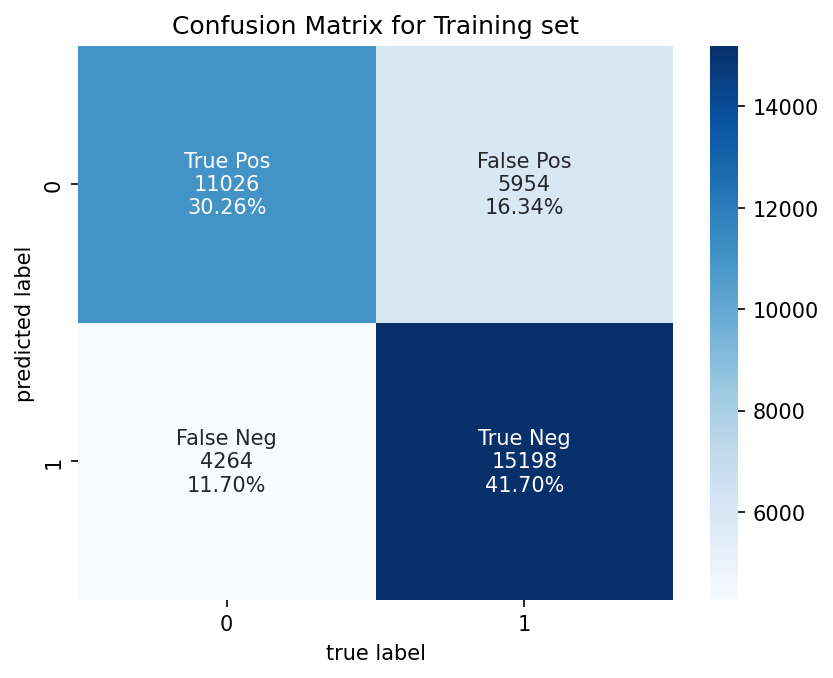

In [43]:
#Confusion Matrix for Train
y_pred = model_naive.predict(X_train)

cm = confusion_matrix(y_train, y_pred)

print("Confusion Matrix:")
print(cm)
plt.figure(dpi=150)

group_names = ['True Pos','False Pos','False Neg','True Neg']

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix for Training set')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()


[[2739 1572]
 [1042 3758]]


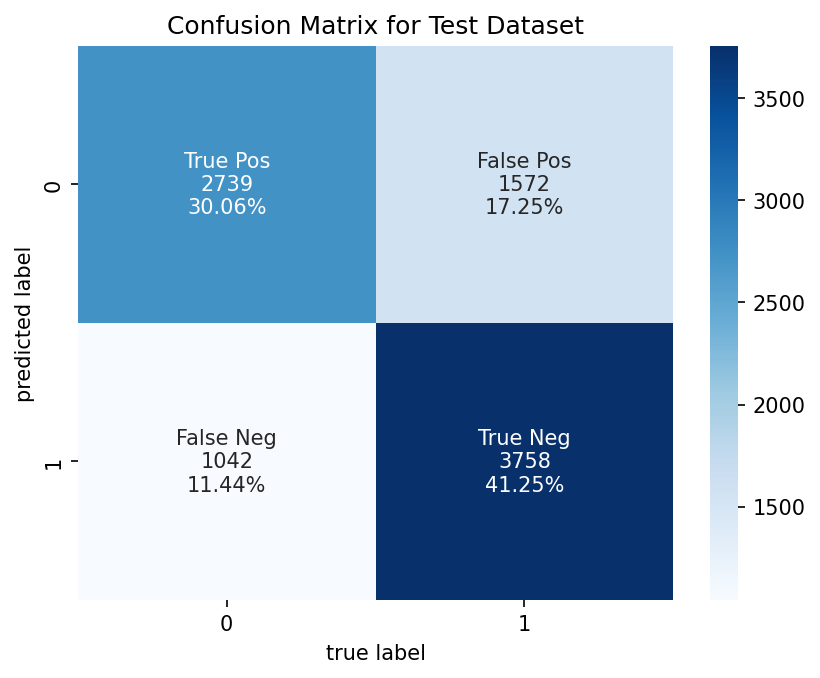

In [44]:
#Confusion matrix for Test
predicted_naive = model_naive.predict(X_test)
mat = confusion_matrix(y_test, predicted_naive)
print(mat)

plt.figure(dpi=150)

group_names = ['True Pos','False Pos','False Neg','True Neg']

group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in mat.flatten()/np.sum(mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mat, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix for Test Dataset')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [45]:
predicted_probabilities = model_naive.predict_proba(X_test)
print((predicted_probabilities))

[[0.4392437  0.5607563 ]
 [0.49854186 0.50145814]
 [0.35052683 0.64947317]
 ...
 [0.07573833 0.92426167]
 [0.57292422 0.42707578]
 [0.20870528 0.79129472]]


In [46]:
positive_probabilities = predicted_probabilities[:, 1]
print(positive_probabilities)

[0.5607563  0.50145814 0.64947317 ... 0.92426167 0.42707578 0.79129472]


In [47]:
negative_probabilities = predicted_probabilities[:, 0]
print(negative_probabilities)

[0.4392437  0.49854186 0.35052683 ... 0.07573833 0.57292422 0.20870528]


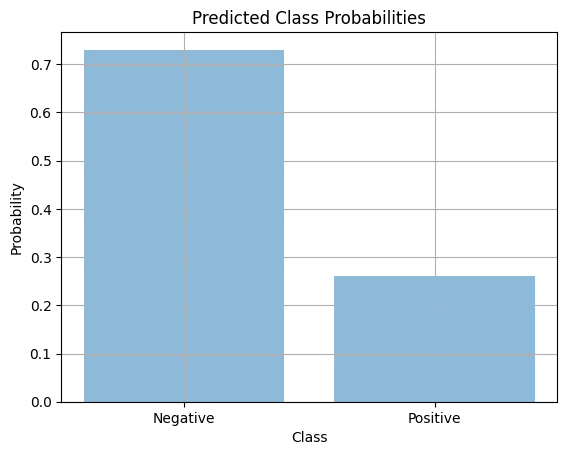

In [48]:
predicted_probabilities = [0.73, 0.26]

class_labels = ['Negative', 'Positive']

x_indices = np.arange(len(class_labels))

plt.bar(x_indices, predicted_probabilities, align='center', alpha=0.5)

plt.xticks(x_indices, class_labels)
plt.ylabel('Probability')
plt.xlabel('Class')
plt.title('Predicted Class Probabilities')
plt.grid(True)

plt.show()

In [49]:
#For Train Dataset
predicted_naive = model_naive.predict(X_train)
score_naive = accuracy_score(predicted_naive, y_train)

error_rate = 1 - score_naive

print("Accuracy: {:.2f}".format(score_naive))
print("Error Rate: {:.2f}".format(error_rate))

Accuracy: 0.72
Error Rate: 0.28


In [50]:
#For Test Dataset
predicted_naive2 = model_naive.predict(X_test)
score_naive2 = accuracy_score(predicted_naive2, y_test)

error_rate2 = 1 - score_naive2

print("Accuracy: {:.2f}".format(score_naive2))
print("Error Rate: {:.2f}".format(error_rate2))

Accuracy: 0.71
Error Rate: 0.29


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_train, predicted_naive))

              precision    recall  f1-score   support

           0       0.72      0.65      0.68     16980
           1       0.72      0.78      0.75     19462

    accuracy                           0.72     36442
   macro avg       0.72      0.72      0.72     36442
weighted avg       0.72      0.72      0.72     36442



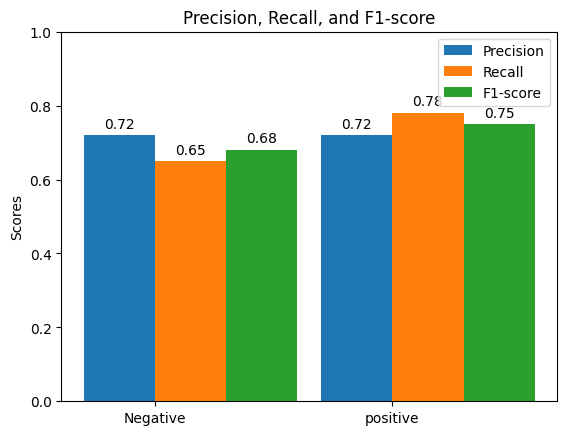

In [52]:
precision = [0.72, 0.72]
recall = [0.65, 0.78]
f1_score = [0.68, 0.75]
labels = ['Negative', 'positive']

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()

Precision = ax.bar(x - width/2, precision, width, label='Precision')
Recall = ax.bar(x + width/2, recall, width, label='Recall')
F1score = ax.bar(x + width*1.5, f1_score, width, label='F1-score')

ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(Precision)
autolabel(Recall)
autolabel(F1score)

plt.ylim(0, 1.0)
plt.show()


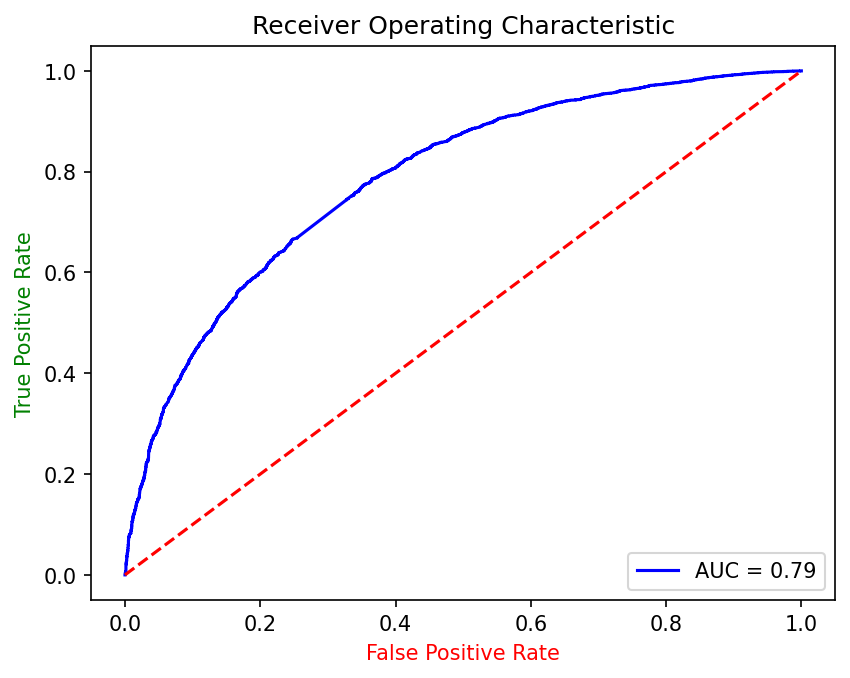

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=150)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()



In [54]:
pip install transformers

In [60]:
from transformers import pipeline

#Load the sentiment analysis model
#model_naive = pipeline("sentiment-analysis")
tweet = "I hate you"
#Analyze the sentiment of the tweet using the loaded model
result = model_naive(tweet)

sentiment_label = result[0]['label']
sentiment_score = result[0]['score']

print("Sentiment Label:", sentiment_label)
print("Sentiment Score:", sentiment_score)

print("Label","test data")

TypeError: ignored